# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.Tanh(),
            nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.Tanh(),
            nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): SELU()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): SELU()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): SELU()
    (7): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if (pred[i,0] - y[i,0] and pred[i,1] - y[i,1]) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/12, Loss: 0.3186
Epoch 1/200, Iteration 2/12, Loss: 2.9264
Epoch 1/200, Iteration 3/12, Loss: 2.4298
Epoch 1/200, Iteration 4/12, Loss: 1.0409
Epoch 1/200, Iteration 5/12, Loss: 0.8179
Epoch 1/200, Iteration 6/12, Loss: 0.9537
Epoch 1/200, Iteration 7/12, Loss: 0.5856
Epoch 1/200, Iteration 8/12, Loss: 0.4526
Epoch 1/200, Iteration 9/12, Loss: 0.5306
Epoch 1/200, Iteration 10/12, Loss: 0.5360
Epoch 1/200, Iteration 11/12, Loss: 0.4439
Epoch 1/200, Iteration 12/12, Loss: 0.3361
Epoch 1/200, Iteration 13/12, Loss: 0.1607
Train Error: 
 Accuracy: 80.12%, Avg loss: 0.281458, MRE: 1.181147 

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.267352, MRE: 1.045099 

Epoch 2/200, Iteration 1/12, Loss: 0.3102
Epoch 2/200, Iteration 2/12, Loss: 0.3406
Epoch 2/200, Iteration 3/12, Loss: 0.2652
Epoch 2/200, Iteration 4/12, Loss: 0.1695
Epoch 2/200, Iteration 5/12, Loss: 0.1785
Epoch 2/200, Iteration 6/12, Loss: 0.1986
Epoch 2/200, Iteration 7/12, Loss: 0.1930
Epoch 2/200, Iterati

Epoch 13/200, Iteration 1/12, Loss: 0.0431
Epoch 13/200, Iteration 2/12, Loss: 0.0572
Epoch 13/200, Iteration 3/12, Loss: 0.0455
Epoch 13/200, Iteration 4/12, Loss: 0.0384
Epoch 13/200, Iteration 5/12, Loss: 0.0341
Epoch 13/200, Iteration 6/12, Loss: 0.0545
Epoch 13/200, Iteration 7/12, Loss: 0.0389
Epoch 13/200, Iteration 8/12, Loss: 0.0508
Epoch 13/200, Iteration 9/12, Loss: 0.0373
Epoch 13/200, Iteration 10/12, Loss: 0.0451
Epoch 13/200, Iteration 11/12, Loss: 0.0349
Epoch 13/200, Iteration 12/12, Loss: 0.0443
Epoch 13/200, Iteration 13/12, Loss: 0.0708
Train Error: 
 Accuracy: 27.88%, Avg loss: 0.048525, MRE: 0.245132 

Test Error: 
 Accuracy: 31.5%, Avg loss: 0.047910, MRE: 0.233687 

Epoch 14/200, Iteration 1/12, Loss: 0.0422
Epoch 14/200, Iteration 2/12, Loss: 0.0292
Epoch 14/200, Iteration 3/12, Loss: 0.0328
Epoch 14/200, Iteration 4/12, Loss: 0.0387
Epoch 14/200, Iteration 5/12, Loss: 0.0402
Epoch 14/200, Iteration 6/12, Loss: 0.0552
Epoch 14/200, Iteration 7/12, Loss: 0.0464


Train Error: 
 Accuracy: 23.88%, Avg loss: 0.047259, MRE: 0.251822 

Test Error: 
 Accuracy: 23.0%, Avg loss: 0.049000, MRE: 0.250216 

Epoch 26/200, Iteration 1/12, Loss: 0.0478
Epoch 26/200, Iteration 2/12, Loss: 0.0607
Epoch 26/200, Iteration 3/12, Loss: 0.0424
Epoch 26/200, Iteration 4/12, Loss: 0.0358
Epoch 26/200, Iteration 5/12, Loss: 0.0562
Epoch 26/200, Iteration 6/12, Loss: 0.0475
Epoch 26/200, Iteration 7/12, Loss: 0.0428
Epoch 26/200, Iteration 8/12, Loss: 0.0572
Epoch 26/200, Iteration 9/12, Loss: 0.0457
Epoch 26/200, Iteration 10/12, Loss: 0.0279
Epoch 26/200, Iteration 11/12, Loss: 0.0392
Epoch 26/200, Iteration 12/12, Loss: 0.0495
Epoch 26/200, Iteration 13/12, Loss: 0.0471
Train Error: 
 Accuracy: 17.12%, Avg loss: 0.042956, MRE: 0.423000 

Test Error: 
 Accuracy: 14.0%, Avg loss: 0.042728, MRE: 0.380573 

Epoch 27/200, Iteration 1/12, Loss: 0.0523
Epoch 27/200, Iteration 2/12, Loss: 0.0561
Epoch 27/200, Iteration 3/12, Loss: 0.0545
Epoch 27/200, Iteration 4/12, Loss: 

Epoch 38/200, Iteration 6/12, Loss: 0.0172
Epoch 38/200, Iteration 7/12, Loss: 0.0221
Epoch 38/200, Iteration 8/12, Loss: 0.0199
Epoch 38/200, Iteration 9/12, Loss: 0.0154
Epoch 38/200, Iteration 10/12, Loss: 0.0250
Epoch 38/200, Iteration 11/12, Loss: 0.0172
Epoch 38/200, Iteration 12/12, Loss: 0.0158
Epoch 38/200, Iteration 13/12, Loss: 0.0302
Train Error: 
 Accuracy: 79.38%, Avg loss: 0.013120, MRE: 0.068515 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.013929, MRE: 0.065658 

Epoch 39/200, Iteration 1/12, Loss: 0.0179
Epoch 39/200, Iteration 2/12, Loss: 0.0154
Epoch 39/200, Iteration 3/12, Loss: 0.0218
Epoch 39/200, Iteration 4/12, Loss: 0.0231
Epoch 39/200, Iteration 5/12, Loss: 0.0199
Epoch 39/200, Iteration 6/12, Loss: 0.0096
Epoch 39/200, Iteration 7/12, Loss: 0.0155
Epoch 39/200, Iteration 8/12, Loss: 0.0106
Epoch 39/200, Iteration 9/12, Loss: 0.0232
Epoch 39/200, Iteration 10/12, Loss: 0.0208
Epoch 39/200, Iteration 11/12, Loss: 0.0175
Epoch 39/200, Iteration 12/12, Loss: 0.01

Epoch 50/200, Iteration 5/12, Loss: 0.0351
Epoch 50/200, Iteration 6/12, Loss: 0.0242
Epoch 50/200, Iteration 7/12, Loss: 0.0101
Epoch 50/200, Iteration 8/12, Loss: 0.0127
Epoch 50/200, Iteration 9/12, Loss: 0.0156
Epoch 50/200, Iteration 10/12, Loss: 0.0153
Epoch 50/200, Iteration 11/12, Loss: 0.0296
Epoch 50/200, Iteration 12/12, Loss: 0.0308
Epoch 50/200, Iteration 13/12, Loss: 0.0163
Train Error: 
 Accuracy: 74.88%, Avg loss: 0.011138, MRE: 0.060496 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.012165, MRE: 0.059229 

Epoch 51/200, Iteration 1/12, Loss: 0.0161
Epoch 51/200, Iteration 2/12, Loss: 0.0233
Epoch 51/200, Iteration 3/12, Loss: 0.0185
Epoch 51/200, Iteration 4/12, Loss: 0.0299
Epoch 51/200, Iteration 5/12, Loss: 0.0261
Epoch 51/200, Iteration 6/12, Loss: 0.0144
Epoch 51/200, Iteration 7/12, Loss: 0.0199
Epoch 51/200, Iteration 8/12, Loss: 0.0193
Epoch 51/200, Iteration 9/12, Loss: 0.0119
Epoch 51/200, Iteration 10/12, Loss: 0.0122
Epoch 51/200, Iteration 11/12, Loss: 0.020

Epoch 62/200, Iteration 2/12, Loss: 0.0149
Epoch 62/200, Iteration 3/12, Loss: 0.0265
Epoch 62/200, Iteration 4/12, Loss: 0.0406
Epoch 62/200, Iteration 5/12, Loss: 0.0211
Epoch 62/200, Iteration 6/12, Loss: 0.0243
Epoch 62/200, Iteration 7/12, Loss: 0.0253
Epoch 62/200, Iteration 8/12, Loss: 0.0229
Epoch 62/200, Iteration 9/12, Loss: 0.0196
Epoch 62/200, Iteration 10/12, Loss: 0.0174
Epoch 62/200, Iteration 11/12, Loss: 0.0214
Epoch 62/200, Iteration 12/12, Loss: 0.0163
Epoch 62/200, Iteration 13/12, Loss: 0.0277
Train Error: 
 Accuracy: 67.0%, Avg loss: 0.019875, MRE: 0.130789 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.020266, MRE: 0.116219 

Epoch 63/200, Iteration 1/12, Loss: 0.0393
Epoch 63/200, Iteration 2/12, Loss: 0.0203
Epoch 63/200, Iteration 3/12, Loss: 0.0189
Epoch 63/200, Iteration 4/12, Loss: 0.0275
Epoch 63/200, Iteration 5/12, Loss: 0.0164
Epoch 63/200, Iteration 6/12, Loss: 0.0166
Epoch 63/200, Iteration 7/12, Loss: 0.0111
Epoch 63/200, Iteration 8/12, Loss: 0.0118
E

Epoch 74/200, Iteration 7/12, Loss: 0.0243
Epoch 74/200, Iteration 8/12, Loss: 0.0104
Epoch 74/200, Iteration 9/12, Loss: 0.0143
Epoch 74/200, Iteration 10/12, Loss: 0.0188
Epoch 74/200, Iteration 11/12, Loss: 0.0162
Epoch 74/200, Iteration 12/12, Loss: 0.0266
Epoch 74/200, Iteration 13/12, Loss: 0.0295
Train Error: 
 Accuracy: 83.5%, Avg loss: 0.007865, MRE: 0.043465 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.008268, MRE: 0.042576 

Epoch 75/200, Iteration 1/12, Loss: 0.0150
Epoch 75/200, Iteration 2/12, Loss: 0.0197
Epoch 75/200, Iteration 3/12, Loss: 0.0211
Epoch 75/200, Iteration 4/12, Loss: 0.0080
Epoch 75/200, Iteration 5/12, Loss: 0.0127
Epoch 75/200, Iteration 6/12, Loss: 0.0335
Epoch 75/200, Iteration 7/12, Loss: 0.0237
Epoch 75/200, Iteration 8/12, Loss: 0.0111
Epoch 75/200, Iteration 9/12, Loss: 0.0123
Epoch 75/200, Iteration 10/12, Loss: 0.0151
Epoch 75/200, Iteration 11/12, Loss: 0.0281
Epoch 75/200, Iteration 12/12, Loss: 0.0210
Epoch 75/200, Iteration 13/12, Loss: 0.01

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007505, MRE: 0.038377 

Epoch 87/200, Iteration 1/12, Loss: 0.0083
Epoch 87/200, Iteration 2/12, Loss: 0.0073
Epoch 87/200, Iteration 3/12, Loss: 0.0083
Epoch 87/200, Iteration 4/12, Loss: 0.0107
Epoch 87/200, Iteration 5/12, Loss: 0.0086
Epoch 87/200, Iteration 6/12, Loss: 0.0248
Epoch 87/200, Iteration 7/12, Loss: 0.0202
Epoch 87/200, Iteration 8/12, Loss: 0.0130
Epoch 87/200, Iteration 9/12, Loss: 0.0085
Epoch 87/200, Iteration 10/12, Loss: 0.0144
Epoch 87/200, Iteration 11/12, Loss: 0.0215
Epoch 87/200, Iteration 12/12, Loss: 0.0198
Epoch 87/200, Iteration 13/12, Loss: 0.0239
Train Error: 
 Accuracy: 92.62%, Avg loss: 0.007198, MRE: 0.043038 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007993, MRE: 0.045093 

Epoch 88/200, Iteration 1/12, Loss: 0.0128
Epoch 88/200, Iteration 2/12, Loss: 0.0152
Epoch 88/200, Iteration 3/12, Loss: 0.0167
Epoch 88/200, Iteration 4/12, Loss: 0.0121
Epoch 88/200, Iteration 5/12, Loss: 0.0233
Epoch 88/200, Itera

Epoch 99/200, Iteration 13/12, Loss: 0.0175
Train Error: 
 Accuracy: 91.0%, Avg loss: 0.006715, MRE: 0.039657 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007327, MRE: 0.039330 

Epoch 100/200, Iteration 1/12, Loss: 0.0330
Epoch 100/200, Iteration 2/12, Loss: 0.0178
Epoch 100/200, Iteration 3/12, Loss: 0.0164
Epoch 100/200, Iteration 4/12, Loss: 0.0133
Epoch 100/200, Iteration 5/12, Loss: 0.0127
Epoch 100/200, Iteration 6/12, Loss: 0.0131
Epoch 100/200, Iteration 7/12, Loss: 0.0168
Epoch 100/200, Iteration 8/12, Loss: 0.0190
Epoch 100/200, Iteration 9/12, Loss: 0.0210
Epoch 100/200, Iteration 10/12, Loss: 0.0112
Epoch 100/200, Iteration 11/12, Loss: 0.0277
Epoch 100/200, Iteration 12/12, Loss: 0.0092
Epoch 100/200, Iteration 13/12, Loss: 0.0149
Train Error: 
 Accuracy: 91.75%, Avg loss: 0.007410, MRE: 0.038578 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007930, MRE: 0.040145 

Epoch 101/200, Iteration 1/12, Loss: 0.0096
Epoch 101/200, Iteration 2/12, Loss: 0.0126
Epoch 101/200, Iterat

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.006266, MRE: 0.035628 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007334, MRE: 0.038240 

Epoch 112/200, Iteration 1/12, Loss: 0.0092
Epoch 112/200, Iteration 2/12, Loss: 0.0131
Epoch 112/200, Iteration 3/12, Loss: 0.0180
Epoch 112/200, Iteration 4/12, Loss: 0.0100
Epoch 112/200, Iteration 5/12, Loss: 0.0086
Epoch 112/200, Iteration 6/12, Loss: 0.0129
Epoch 112/200, Iteration 7/12, Loss: 0.0175
Epoch 112/200, Iteration 8/12, Loss: 0.0137
Epoch 112/200, Iteration 9/12, Loss: 0.0152
Epoch 112/200, Iteration 10/12, Loss: 0.0146
Epoch 112/200, Iteration 11/12, Loss: 0.0137
Epoch 112/200, Iteration 12/12, Loss: 0.0196
Epoch 112/200, Iteration 13/12, Loss: 0.0273
Train Error: 
 Accuracy: 94.38%, Avg loss: 0.006676, MRE: 0.036318 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007663, MRE: 0.038689 

Epoch 113/200, Iteration 1/12, Loss: 0.0174
Epoch 113/200, Iteration 2/12, Loss: 0.0180
Epoch 113/200, Iteration 3/12, Loss: 0.0116
Epoch 113/200, Itera

Epoch 123/200, Iteration 9/12, Loss: 0.0147
Epoch 123/200, Iteration 10/12, Loss: 0.0274
Epoch 123/200, Iteration 11/12, Loss: 0.0110
Epoch 123/200, Iteration 12/12, Loss: 0.0129
Epoch 123/200, Iteration 13/12, Loss: 0.0264
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.006578, MRE: 0.035985 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.007858, MRE: 0.039860 

Epoch 124/200, Iteration 1/12, Loss: 0.0077
Epoch 124/200, Iteration 2/12, Loss: 0.0174
Epoch 124/200, Iteration 3/12, Loss: 0.0213
Epoch 124/200, Iteration 4/12, Loss: 0.0140
Epoch 124/200, Iteration 5/12, Loss: 0.0091
Epoch 124/200, Iteration 6/12, Loss: 0.0091
Epoch 124/200, Iteration 7/12, Loss: 0.0138
Epoch 124/200, Iteration 8/12, Loss: 0.0095
Epoch 124/200, Iteration 9/12, Loss: 0.0191
Epoch 124/200, Iteration 10/12, Loss: 0.0173
Epoch 124/200, Iteration 11/12, Loss: 0.0079
Epoch 124/200, Iteration 12/12, Loss: 0.0167
Epoch 124/200, Iteration 13/12, Loss: 0.0208
Train Error: 
 Accuracy: 91.38%, Avg loss: 0.006428, MRE: 0.0406

Train Error: 
 Accuracy: 91.38%, Avg loss: 0.006305, MRE: 0.034460 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007139, MRE: 0.036932 

Epoch 136/200, Iteration 1/12, Loss: 0.0106
Epoch 136/200, Iteration 2/12, Loss: 0.0140
Epoch 136/200, Iteration 3/12, Loss: 0.0094
Epoch 136/200, Iteration 4/12, Loss: 0.0157
Epoch 136/200, Iteration 5/12, Loss: 0.0102
Epoch 136/200, Iteration 6/12, Loss: 0.0124
Epoch 136/200, Iteration 7/12, Loss: 0.0175
Epoch 136/200, Iteration 8/12, Loss: 0.0141
Epoch 136/200, Iteration 9/12, Loss: 0.0206
Epoch 136/200, Iteration 10/12, Loss: 0.0159
Epoch 136/200, Iteration 11/12, Loss: 0.0140
Epoch 136/200, Iteration 12/12, Loss: 0.0114
Epoch 136/200, Iteration 13/12, Loss: 0.0255
Train Error: 
 Accuracy: 92.88%, Avg loss: 0.006438, MRE: 0.034975 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007130, MRE: 0.037228 

Epoch 137/200, Iteration 1/12, Loss: 0.0143
Epoch 137/200, Iteration 2/12, Loss: 0.0121
Epoch 137/200, Iteration 3/12, Loss: 0.0251
Epoch 137/200, Itera

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.006263, MRE: 0.034768 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006993, MRE: 0.036778 

Epoch 148/200, Iteration 1/12, Loss: 0.0126
Epoch 148/200, Iteration 2/12, Loss: 0.0076
Epoch 148/200, Iteration 3/12, Loss: 0.0100
Epoch 148/200, Iteration 4/12, Loss: 0.0183
Epoch 148/200, Iteration 5/12, Loss: 0.0199
Epoch 148/200, Iteration 6/12, Loss: 0.0093
Epoch 148/200, Iteration 7/12, Loss: 0.0149
Epoch 148/200, Iteration 8/12, Loss: 0.0099
Epoch 148/200, Iteration 9/12, Loss: 0.0214
Epoch 148/200, Iteration 10/12, Loss: 0.0120
Epoch 148/200, Iteration 11/12, Loss: 0.0095
Epoch 148/200, Iteration 12/12, Loss: 0.0121
Epoch 148/200, Iteration 13/12, Loss: 0.0110
Train Error: 
 Accuracy: 92.0%, Avg loss: 0.006160, MRE: 0.034367 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.006986, MRE: 0.036307 

Epoch 149/200, Iteration 1/12, Loss: 0.0178
Epoch 149/200, Iteration 2/12, Loss: 0.0094
Epoch 149/200, Iteration 3/12, Loss: 0.0179
Epoch 149/200, Iterati

Epoch 160/200, Iteration 4/12, Loss: 0.0238
Epoch 160/200, Iteration 5/12, Loss: 0.0289
Epoch 160/200, Iteration 6/12, Loss: 0.0179
Epoch 160/200, Iteration 7/12, Loss: 0.0255
Epoch 160/200, Iteration 8/12, Loss: 0.0193
Epoch 160/200, Iteration 9/12, Loss: 0.0156
Epoch 160/200, Iteration 10/12, Loss: 0.0182
Epoch 160/200, Iteration 11/12, Loss: 0.0145
Epoch 160/200, Iteration 12/12, Loss: 0.0249
Epoch 160/200, Iteration 13/12, Loss: 0.0340
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.006148, MRE: 0.033972 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007099, MRE: 0.036629 

Epoch 161/200, Iteration 1/12, Loss: 0.0106
Epoch 161/200, Iteration 2/12, Loss: 0.0159
Epoch 161/200, Iteration 3/12, Loss: 0.0123
Epoch 161/200, Iteration 4/12, Loss: 0.0190
Epoch 161/200, Iteration 5/12, Loss: 0.0148
Epoch 161/200, Iteration 6/12, Loss: 0.0210
Epoch 161/200, Iteration 7/12, Loss: 0.0166
Epoch 161/200, Iteration 8/12, Loss: 0.0117
Epoch 161/200, Iteration 9/12, Loss: 0.0096
Epoch 161/200, Iteration

Epoch 172/200, Iteration 13/12, Loss: 0.0097
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.006140, MRE: 0.034663 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.007362, MRE: 0.038081 

Epoch 173/200, Iteration 1/12, Loss: 0.0082
Epoch 173/200, Iteration 2/12, Loss: 0.0162
Epoch 173/200, Iteration 3/12, Loss: 0.0172
Epoch 173/200, Iteration 4/12, Loss: 0.0237
Epoch 173/200, Iteration 5/12, Loss: 0.0234
Epoch 173/200, Iteration 6/12, Loss: 0.0243
Epoch 173/200, Iteration 7/12, Loss: 0.0093
Epoch 173/200, Iteration 8/12, Loss: 0.0157
Epoch 173/200, Iteration 9/12, Loss: 0.0161
Epoch 173/200, Iteration 10/12, Loss: 0.0247
Epoch 173/200, Iteration 11/12, Loss: 0.0153
Epoch 173/200, Iteration 12/12, Loss: 0.0164
Epoch 173/200, Iteration 13/12, Loss: 0.0217
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.006564, MRE: 0.036332 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.007410, MRE: 0.037547 

Epoch 174/200, Iteration 1/12, Loss: 0.0194
Epoch 174/200, Iteration 2/12, Loss: 0.0311
Epoch 174/200, Itera

Epoch 185/200, Iteration 3/12, Loss: 0.0111
Epoch 185/200, Iteration 4/12, Loss: 0.0163
Epoch 185/200, Iteration 5/12, Loss: 0.0107
Epoch 185/200, Iteration 6/12, Loss: 0.0236
Epoch 185/200, Iteration 7/12, Loss: 0.0177
Epoch 185/200, Iteration 8/12, Loss: 0.0170
Epoch 185/200, Iteration 9/12, Loss: 0.0176
Epoch 185/200, Iteration 10/12, Loss: 0.0134
Epoch 185/200, Iteration 11/12, Loss: 0.0233
Epoch 185/200, Iteration 12/12, Loss: 0.0129
Epoch 185/200, Iteration 13/12, Loss: 0.0414
Train Error: 
 Accuracy: 92.12%, Avg loss: 0.007738, MRE: 0.038780 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.008630, MRE: 0.040174 

Epoch 186/200, Iteration 1/12, Loss: 0.0149
Epoch 186/200, Iteration 2/12, Loss: 0.0121
Epoch 186/200, Iteration 3/12, Loss: 0.0251
Epoch 186/200, Iteration 4/12, Loss: 0.0223
Epoch 186/200, Iteration 5/12, Loss: 0.0089
Epoch 186/200, Iteration 6/12, Loss: 0.0258
Epoch 186/200, Iteration 7/12, Loss: 0.0121
Epoch 186/200, Iteration 8/12, Loss: 0.0102
Epoch 186/200, Iteration

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.007307, MRE: 0.037837 

Epoch 197/200, Iteration 1/12, Loss: 0.0081
Epoch 197/200, Iteration 2/12, Loss: 0.0157
Epoch 197/200, Iteration 3/12, Loss: 0.0149
Epoch 197/200, Iteration 4/12, Loss: 0.0128
Epoch 197/200, Iteration 5/12, Loss: 0.0183
Epoch 197/200, Iteration 6/12, Loss: 0.0099
Epoch 197/200, Iteration 7/12, Loss: 0.0109
Epoch 197/200, Iteration 8/12, Loss: 0.0190
Epoch 197/200, Iteration 9/12, Loss: 0.0135
Epoch 197/200, Iteration 10/12, Loss: 0.0223
Epoch 197/200, Iteration 11/12, Loss: 0.0154
Epoch 197/200, Iteration 12/12, Loss: 0.0322
Epoch 197/200, Iteration 13/12, Loss: 0.0163
Train Error: 
 Accuracy: 94.5%, Avg loss: 0.006423, MRE: 0.035229 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007694, MRE: 0.039428 

Epoch 198/200, Iteration 1/12, Loss: 0.0208
Epoch 198/200, Iteration 2/12, Loss: 0.0158
Epoch 198/200, Iteration 3/12, Loss: 0.0252
Epoch 198/200, Iteration 4/12, Loss: 0.0099
Epoch 198/200, Iteration 5/12, Loss: 0.0136
Ep

#### Plots loss vs Epoch

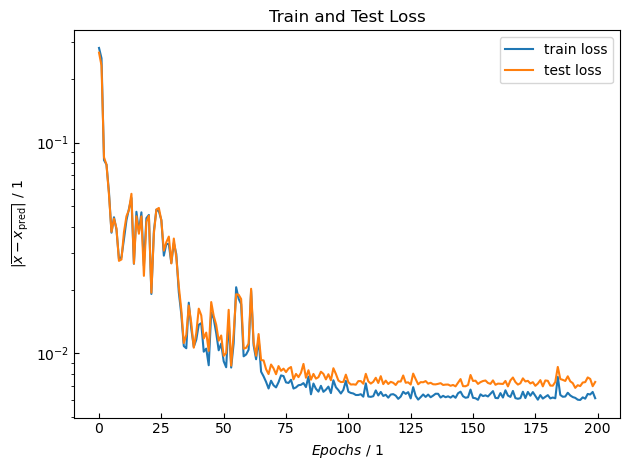

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\overline{x - x\mathregular{_{pred}}}$| / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9813612375952919 , R^2(NH3) = 0.9530376954267497
Test Dataset: R^2(H2) = 0.9835994834623384 , R^2(NH3) = 0.9578240819017498
Max Error Training: |x_H2 - x_H2,pred| = 0.1323470122869015 , |x_NH3 - x_NH3,pred| = 0.1392303693602436
Max Error Test: |x_H2 - x_H2,pred| = 0.10941509895798596 , |x_NH3 - x_NH3,pred| = 0.08179939419550036


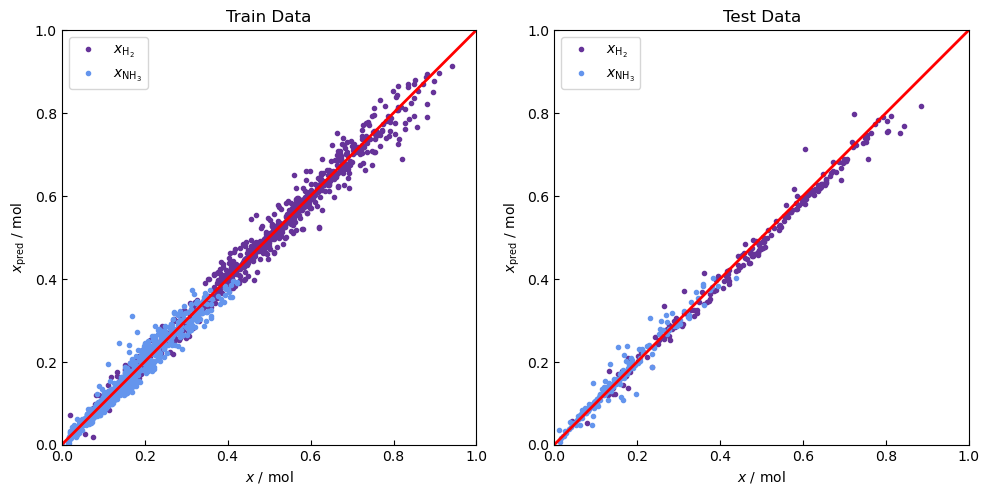

In [11]:
x_H2_real = []
x_H2_pred = []
x_NH3_real = []
x_NH3_pred = []
for (X,y) in train_dataloader:
    x_H2_real = np.append(x_H2_real, y[:,0].numpy())
    x_NH3_real = np.append(x_NH3_real, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred = np.append(x_H2_pred, help_x_H2)
    x_NH3_pred = np.append(x_NH3_pred, help_x_NH3)

x_H2_real_test = []
x_H2_pred_test = []
x_NH3_real_test = []
x_NH3_pred_test = []
for (X,y) in test_dataloader:
    x_H2_real_test = np.append(x_H2_real_test, y[:,0].numpy())
    x_NH3_real_test = np.append(x_NH3_real_test, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test = np.append(x_H2_pred_test, help_x_H2)
    x_NH3_pred_test = np.append(x_NH3_pred_test, help_x_NH3)

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

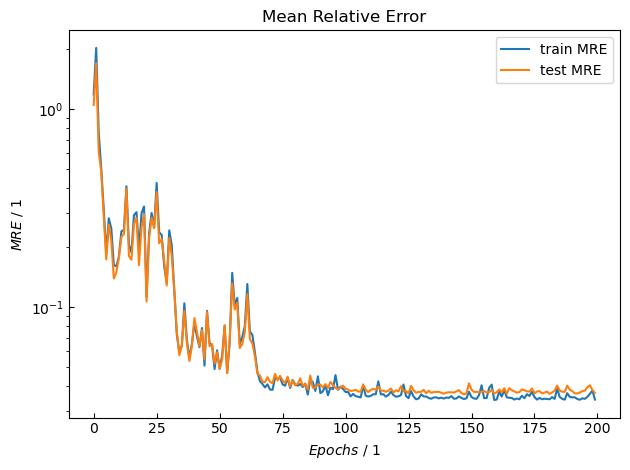

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_MRE, label='train MRE')
ax.semilogy(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

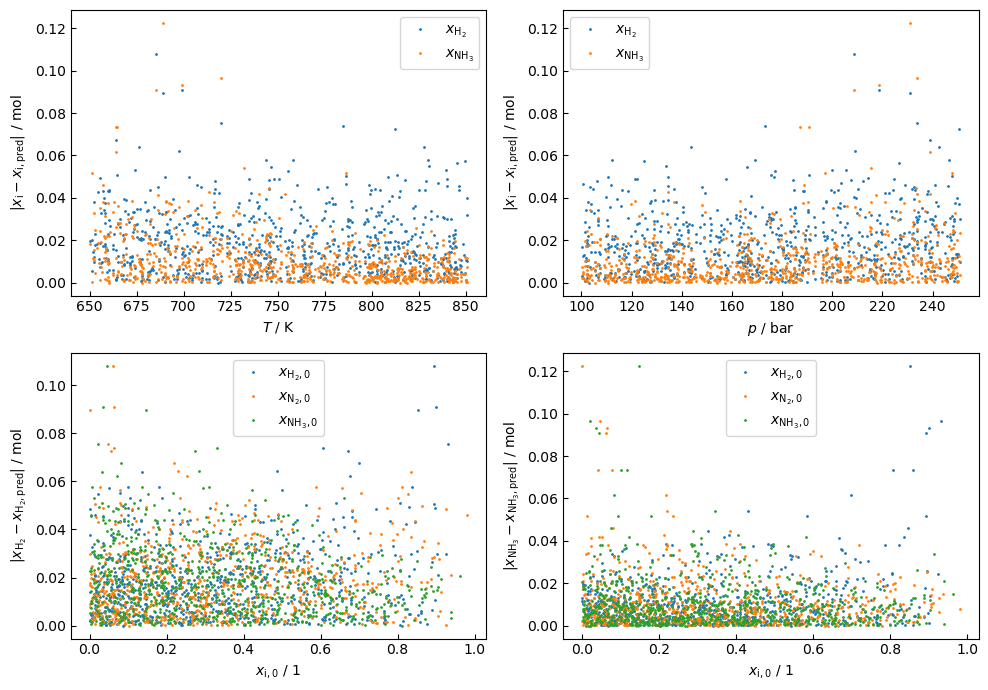

In [13]:
mistake_H2 = []
mistake_NH3 = []
param_T = []
param_p = []
param_x_H2_0 = []
param_x_N2_0 = []
param_x_NH3_0 = []
for X,y in train_dataloader:
    help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
    mistake_H2 = np.append(mistake_H2, help_mistake_H2)
    mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3)
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2_0 = np.append(param_x_H2_0, X[:,2])
    param_x_N2_0 = np.append(param_x_N2_0, X[:,3])
    param_x_NH3_0 = np.append(param_x_NH3_0, X[:,4])

# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].plot(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].plot(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].plot(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].plot(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].plot(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].plot(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].plot(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].legend()

ax[1,1].plot(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].plot(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].plot(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].legend()

plt.tight_layout()
plt.show()

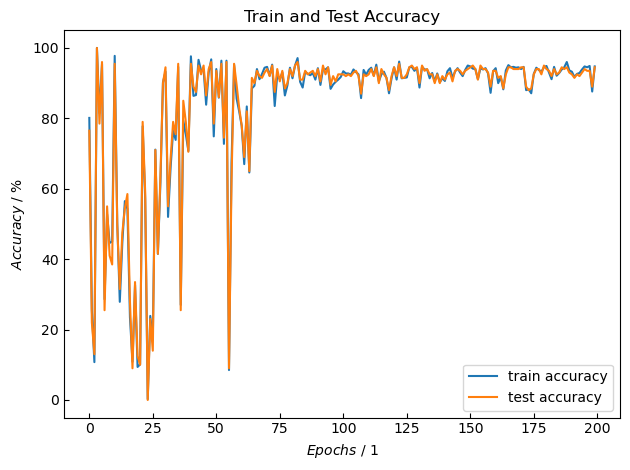

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[7.4485e+02, 2.0845e+02, 3.2110e-01, 1.1262e-01, 5.6628e-01],
        [8.2849e+02, 2.0229e+02, 2.5316e-01, 3.6873e-01, 3.7811e-01],
        [6.9012e+02, 2.4374e+02, 2.0514e-01, 2.5559e-01, 5.3927e-01],
        [8.1373e+02, 2.3689e+02, 6.4033e-01, 1.5029e-01, 2.0938e-01],
        [8.3313e+02, 2.3216e+02, 7.7468e-01, 2.3975e-02, 2.0135e-01],
        [8.0334e+02, 2.0477e+02, 8.3453e-02, 2.8681e-01, 6.2973e-01],
        [7.4082e+02, 2.0836e+02, 6.0084e-01, 5.4706e-02, 3.4445e-01],
        [6.9290e+02, 2.5000e+02, 8.8509e-02, 3.6655e-02, 8.7484e-01],
        [7.4466e+02, 1.1034e+02, 1.8068e-01, 6.2309e-01, 1.9623e-01],
        [7.6797e+02, 1.6381e+02, 4.5463e-01, 9.5059e-02, 4.5031e-01],
        [6.9607e+02, 1.6462e+02, 2.7560e-01, 2.3890e-01, 4.8549e-01],
        [6.7285e+02, 1.4258e+02, 6.6011e-01, 1.8309e-01, 1.5680e-01],
        [8.1793e+02, 1.5009e+02, 3.7963e-01, 4.9517e-01, 1.2520e-01],
        [6.9069e+02, 1.2115e+02, 3.0751e-01, 4.1011e-01, 2.8238e-01],
        [8.1414e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.6441, 0.5830, 0.6489, 0.6951, 0.7949], requires_grad=True),
 Parameter containing:
 tensor([ 0.0461, -0.0726, -0.0391,  0.0079, -0.0522], requires_grad=True),
 Parameter containing:
 tensor([[-9.0705e-02, -7.6969e-02, -2.6377e-01, -2.4260e-01, -2.1299e-01],
         [ 1.3753e-01,  3.0296e-02, -1.2040e-01, -1.6726e-01, -1.4604e-01],
         [ 2.0467e-01, -9.9463e-03, -1.3513e-01, -2.1830e-01, -7.5172e-02],
         [ 2.1032e-01, -5.4119e-02,  1.1782e-01, -1.0637e-01,  3.0763e-03],
         [-4.6060e-02, -8.6142e-02,  2.2371e-01,  1.9941e-01,  2.8374e-01],
         [-3.5626e-02,  2.8839e-01,  1.9512e-01,  1.6158e-01,  7.0042e-02],
         [ 2.3487e-01,  2.4597e-01,  1.5725e-02,  2.9027e-01,  1.3961e-01],
         [ 6.1351e-02,  4.9147e-02, -2.1684e-01, -2.3048e-01, -1.8086e-01],
         [ 6.1884e-02,  3.8288e-02,  1.3478e-01, -1.6458e-01,  1.3771e-01],
         [ 2.0766e-01, -1.2564e-01,  1.2807e-01,  2.2503e-01,  5.8483e-02],
         [-7.2842e-02,  

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.5181, 0.4143, 0.1218, 0.2484, 0.0021],
        [0.1073, 0.3863, 0.2313, 0.8497, 0.2696]])
tensor([[ 0.4818, -0.0352],
        [ 0.4528,  0.2360]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[6.6790e+02, 1.7861e+02, 1.6632e-01, 5.0623e-01, 3.2745e-01],
        [7.8692e+02, 2.4046e+02, 4.3439e-01, 2.9990e-01, 2.6572e-01],
        [7.7419e+02, 2.1713e+02, 1.3585e-01, 4.4475e-01, 4.1940e-01],
        [7.7637e+02, 2.1757e+02, 6.9804e-01, 8.2687e-02, 2.1927e-01],
        [7.6593e+02, 2.0384e+02, 2.4871e-01, 4.4897e-01, 3.0232e-01],
        [7.6746e+02, 1.3156e+02, 7.8491e-02, 7.2293e-02, 8.4922e-01],
        [8.4446e+02, 1.4240e+02, 3.8437e-01, 1.7558e-01, 4.4005e-01],
        [8.3774e+02, 2.3518e+02, 3.5978e-01, 7.8120e-02, 5.6210e-01],
        [8.4991e+02, 2.1020e+02, 5.6912e-01, 2.0842e-01, 2.2246e-01],
        [7.8149e+02, 2.2675e+02, 2.5981e-01, 1.7205e-01, 5.6814e-01],
        [8.0157e+02, 2.1055e+02, 5.2086e-01, 3.4680e-01, 1.3234e-01],
        [7.4443e+02, 1.9108e+02, 3.3323e-01, 2.3230e-01, 4.3447e-01],
        [7.6670e+02, 1.1162e+02, 2.6383e-01, 7.1124e-01, 2.4925e-02],
        [8.2848e+02, 1.9252e+02, 7.4902e-01, 9.1220e-02, 1.5976e-01],
        [7.7121e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()